In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Data Cleaning

In [2]:
sales = pd.read_parquet('sale_sample_18-21.parquet')
townships = gpd.read_file('townships.geojson')
char_sample = pd.read_csv('char_sample.csv', dtype={'class': str}) # also has 'EX' in column
#geo_info = pd.read_csv('parcels_geoinfo.csv')

sales.rename(columns={'township_code': 'township'}, inplace=True)
sales.year = sales.year.astype(int)
sales.pin = sales.pin.astype(int)
#sales.township = sales.township.astype(int)
#townships.township = townships.township.astype(int)
sales = pd.merge(sales, char_sample, on=['pin', 'year'])
#sales = pd.merge(sales, char_sample, on=['pin', 'year', 'class']) # gets rid of a few too many PINs
#geo_sales = sales.merge(geo_info, on='pin')

# Variance - Outlier Detection

Just check number of deivations away from mean grouped by township.

Problems:

Would like to vary by geography, but how to join new geographies to table to do that? What is value in common? With spatial dataset could see what PINS in what unit, but we have no lat/long for data.


In [3]:
def is_outlier_groupby(s):
    """
    Finds values outside of std deviation range.
    Function meant for groupby() only.
    """
    lower_limit = s.mean() - (s.std() * 4)
    upper_limit = s.mean() + (s.std() * 4)
    return ~s.between(lower_limit, upper_limit)

std_outliers = sales[sales.groupby('township')['sale_price_log10'].apply(is_outlier_groupby)]
no_std_outliers = sales[~sales.groupby('township')['sale_price_log10'].apply(is_outlier_groupby)]

<AxesSubplot:ylabel='Frequency'>

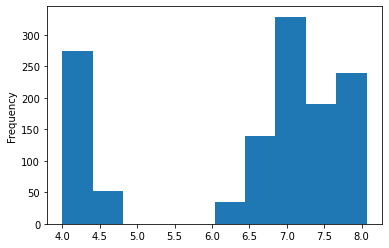

In [4]:
std_outliers.sale_price_log10.plot.hist()

<AxesSubplot:ylabel='Frequency'>

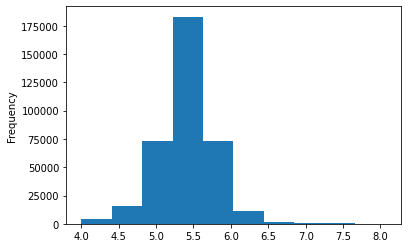

In [5]:
sales.sale_price_log10.plot.hist()

<AxesSubplot:ylabel='Frequency'>

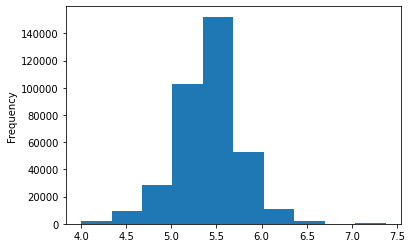

In [6]:
no_std_outliers.sale_price_log10.plot.hist()

In [7]:
len(std_outliers)

1258

In [8]:
len(std_outliers) / len(sales) * 100

0.3473411011099453

([<matplotlib.patches.Wedge at 0x7f8f42c619c0>,
 [Text(-1.0999345110551924, 0.012002974205377387, ''),
  Text(1.0999345114327184, -0.012002939609424822, '')])

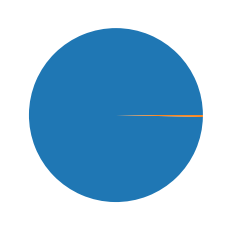

In [9]:
plt.pie(np.array([len(no_std_outliers), len(std_outliers)]))

### $ per sqft

In [10]:
sales['price_per_sqft'] = sales['sale_price'] / sales['sqft']
sales['price_per_sqft_log10'] = sales['sale_price_log10'] / sales['sqft']
sales['price_per_sqft'].replace([np.inf, -np.inf], np.nan, inplace=True)
sales['price_per_sqft_log10'].replace([np.inf, -np.inf], np.nan, inplace=True)

<AxesSubplot:ylabel='Frequency'>

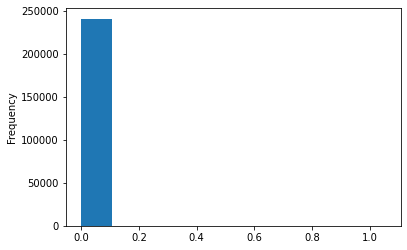

In [11]:
sales.price_per_sqft_log10.plot.hist()

<AxesSubplot:ylabel='Frequency'>

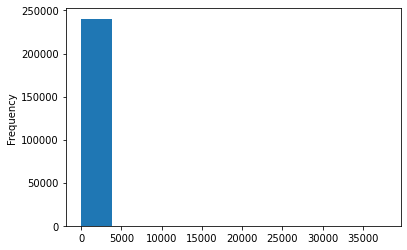

In [12]:
sales.price_per_sqft.plot.hist()

In [13]:
sqft_outliers = sales.dropna(subset=['price_per_sqft'])[sales.groupby('township')['price_per_sqft'].apply(is_outlier_groupby)]
no_sqft_outliers = sales.dropna(subset=['price_per_sqft'])[~sales.groupby('township')['price_per_sqft'].apply(is_outlier_groupby)]

/tmp/ipykernel_110481/2451155155.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sqft_outliers = sales.dropna(subset=['price_per_sqft'])[sales.groupby('township')['price_per_sqft'].apply(is_outlier_groupby)]
/tmp/ipykernel_110481/2451155155.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_sqft_outliers = sales.dropna(subset=['price_per_sqft'])[~sales.groupby('township')['price_per_sqft'].apply(is_outlier_groupby)]


<AxesSubplot:ylabel='Frequency'>

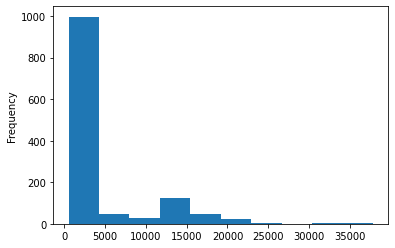

In [14]:
sqft_outliers.price_per_sqft.plot.hist()

<AxesSubplot:ylabel='Frequency'>

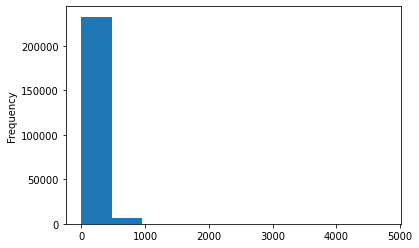

In [15]:
no_sqft_outliers.price_per_sqft.plot.hist()

<AxesSubplot:ylabel='Frequency'>

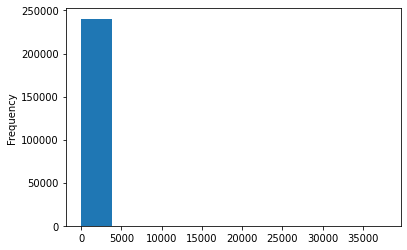

In [16]:
sales.price_per_sqft.plot.hist()

In [17]:
len(sqft_outliers)

1277

In [18]:
len(sqft_outliers) / len(sales) * 100

0.35258711138108123

([<matplotlib.patches.Wedge at 0x7f8f6824a470>,
 [Text(-1.099847256293023, 0.01833065259911805, ''),
  Text(1.0998472561589419, -0.01833066064405022, '')])

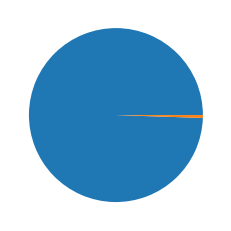

In [19]:
plt.pie(np.array([len(no_sqft_outliers), len(sqft_outliers)]))

##### Overlaps

In [20]:
std_outliers

,pin,year,township,class_x,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_buyer_exercising_an_option_to_purchase,is_simultaneous_trade_of_property,is_sale_leaseback,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,class_y,sqft,year_built
933,13292140080000,2019,71,204,2019-02-01 00:00:00+00:00,32000.0,4.505150,97183306.0,1907441028,02,...,0,0,0,0,0.0,0.0,0.0,204,2054.0,1925.0
1414,17084300050000,2018,77,212,2018-05-01 00:00:00+00:00,10000000.0,7.000000,96890312.0,1813706236,05,...,None,None,None,None,NaN,NaN,NaN,212,7561.0,1889.0
1719,9094030682190,2019,22,299,2019-11-01 00:00:00+00:00,8833798.0,6.946147,98223441.0,1935817044,05,...,None,None,None,None,NaN,NaN,NaN,299,NaN,1973.0
2407,13291260431008,2022,71,299,2022-02-17 00:00:00+00:00,3875000.0,6.588272,7298426.0,2205622035,05,...,None,None,None,None,NaN,NaN,NaN,299,NaN,2009.0
2509,14323060241018,2018,77,299,2018-07-01 00:00:00+00:00,15000.0,4.176091,97447556.0,1823322030,05,...,0,0,0,0,0.0,0.0,0.0,299,NaN,1923.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359997,14211100481928,2020,73,299,2020-04-01 00:00:00+00:00,12500.0,4.096910,97519856.0,2016357199,01,...,0,0,0,0,0.0,0.0,0.0,299,NaN,1987.0
361381,14211010542115,2021,73,299,2021-11-04 00:00:00+00:00,16000.0,4.204120,7266553.0,2132021080,01,...,0,0,0,0,0.0,0.0,0.0,299,NaN,1975.0
361448,6183000861015,2020,18,299,2020-02-01 00:00:00+00:00,40500.0,4.607455,96221162.0,2007613064,01,...,0,0,0,0,0.0,0.0,0.0,299,478.0,1972.0
361553,15124290621004,2018,31,299,2018-09-01 00:00:00+00:00,4990000.0,6.698101,96995688.0,1824949137,01,...,None,None,None,None,NaN,NaN,NaN,299,NaN,1972.0


In [21]:
sqft_outliers

,pin,year,township,class_x,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_sale_leaseback,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,class_y,sqft,year_built,price_per_sqft,price_per_sqft_log10
1003,17173100260000,2021,77,211,2021-03-18 00:00:00+00:00,1080000.0,6.033424,7164750.0,2111101126,01,...,0,0,0.0,0.0,0.0,205,750.0,1873.0,1440.000000,0.008045
1014,17064160420000,2021,77,211,2021-06-10 00:00:00+00:00,1950000.0,6.290035,7211833.0,2120401382,01,...,0,1,689.0,0.0,0.0,211,1512.0,1878.0,1289.682540,0.004160
1414,17084300050000,2018,77,212,2018-05-01 00:00:00+00:00,10000000.0,7.000000,96890312.0,1813706236,05,...,None,None,NaN,NaN,NaN,212,7561.0,1889.0,1322.576379,0.000926
1676,4244020410000,2020,25,202,2020-04-01 00:00:00+00:00,901000.0,5.954725,96592442.0,2014821026,01,...,0,0,0.0,0.0,0.0,202,835.0,1952.0,1079.041916,0.007131
1765,4364000250000,2019,25,204,2019-03-01 00:00:00+00:00,2300000.0,6.361728,96442005.0,1908740008,01,...,0,0,0.0,0.0,0.0,204,2148.0,1951.0,1070.763501,0.002962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361179,13133290070000,2019,71,202,2019-02-01 00:00:00+00:00,834500.0,5.921426,97183651.0,1903613006,01,...,0,0,0.0,0.0,0.0,202,681.0,1916.0,1225.403818,0.008695
361273,33073060160000,2020,12,203,2020-12-29 00:00:00+00:00,784554.0,5.894623,7108183.0,2036422036,05,...,0,0,0.0,0.0,0.0,203,1043.0,1974.0,752.209012,0.005652
361610,25203020430000,2020,72,203,2020-05-01 00:00:00+00:00,862245.0,5.935631,98483876.0,2030244007,01,...,None,None,NaN,NaN,NaN,203,1233.0,1966.0,699.306569,0.004814
362044,17081200160000,2022,77,211,2022-02-16 00:00:00+00:00,895000.0,5.951823,7313535.0,2208255008,01,...,None,None,NaN,NaN,NaN,205,724.0,1901.0,1236.187845,0.008221


In [22]:
overlap = pd.merge(std_outliers, sqft_outliers)

In [23]:
len(overlap)

275

In [24]:
overlap.pin.value_counts()

27174040460000    5
27174040450000    3
4202010060000     2
3042010261121     1
3042010261160     1
                 ..
3042010261165     1
3042010261007     1
3042010261265     1
3042010261058     1
8232010710000     1
Name: pin, Length: 268, dtype: int64

# Sale Volatility

Get average % change in price for properties in township for all time and then mark outlier properties.

Problems:
Get clarification on Growth Rate vs Sale Price Volatility

There is not a consistent amount of periods(year or transactions) for any property. So how to calculate the change over specific time periods for each property? Especially without iterating over the dataframe or over smaller dataframes, which would be disgustingly slow.

Create buckets of which properties fall into which growth rates. Look at absolute value change, see if departing from value of area or moving towards.
See what portion of data illustrates particular outlier flag, and which ones illustrate several outlier flags.

In [25]:
sales['pct'] = sales.sort_values('sale_date').groupby('pin')['sale_price'].pct_change()
township_avg_change = sales.groupby('township')['pct'].mean()
township_mean = sales.groupby('township')['sale_price_log10'].mean()


sales.set_index('township', inplace=True)
sales['township_avg_change'] = township_avg_change
sales['township_mean_sale_log10'] = township_mean
sales['diff_from_township_mean_sale_log10'] = abs(sales['township_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

#sales['price_movement'] = 'toward'
#sales.loc[sales['sale_price'] is further away from township mean than last sales price, 'price_movement'] = 'away'

<AxesSubplot:xlabel='township_mean_sale_log10', ylabel='township_avg_change'>

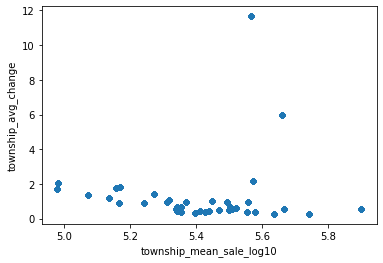

In [26]:
sales.plot.scatter(x='township_mean_sale_log10', y='township_avg_change')

In [27]:
sales[sales['township'] == '76']

,township,pin,year,class_x,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,homestead_exemption_senior_citizens_assessment_freeze,class_y,sqft,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10
11,76,16364000080000,2018,211,2018-10-01 00:00:00+00:00,118000.0,5.071882,97299586.0,1831319495,01,...,0.00,211,1344.0,1888.0,87.797619,0.003774,NaN,11.660976,5.565934,0.494052
21,76,17314120190000,2018,211,2018-12-01 00:00:00+00:00,221000.0,5.344392,98256241.0,1836134037,05,...,0.00,211,4092.0,1897.0,54.007820,0.001306,NaN,11.660976,5.565934,0.221542
33,76,17294270430000,2018,211,2018-02-01 00:00:00+00:00,236000.0,5.372912,97298082.0,1805841021,01,...,0.00,211,1224.0,1894.0,192.810458,0.004390,0.000000,11.660976,5.565934,0.193022
34,76,17294270430000,2018,211,2018-02-01 00:00:00+00:00,236000.0,5.372912,97298082.0,1805841021,01,...,0.00,211,1400.0,1864.0,168.571429,0.003838,NaN,11.660976,5.565934,0.193022
85,76,17314180080000,2018,203,2018-07-01 00:00:00+00:00,265000.0,5.423246,96705202.0,1820718048,01,...,0.00,203,1575.0,1888.0,168.253968,0.003443,NaN,11.660976,5.565934,0.142688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361625,76,17221101001394,2019,299,2019-05-01 00:00:00+00:00,440000.0,5.643453,96330120.0,1917708026,01,...,NaN,299,NaN,2002.0,NaN,NaN,NaN,11.660976,5.565934,0.077518
361952,76,17312210040000,2020,203,2020-09-16 00:00:00+00:00,310000.0,5.491362,7098657.0,2032507219,01,...,0.00,203,1573.0,1893.0,197.075652,0.003491,NaN,11.660976,5.565934,0.074572
361989,76,17282110020000,2018,212,2018-04-01 00:00:00+00:00,570000.0,5.755875,98336720.0,1810318075,01,...,0.00,212,3060.0,1891.0,186.274510,0.001881,NaN,11.660976,5.565934,0.189941
362056,76,17284270280000,2018,212,2018-07-01 00:00:00+00:00,688000.0,5.837588,96445699.0,1820644051,01,...,0.00,212,5952.0,2005.0,115.591398,0.000981,NaN,11.660976,5.565934,0.271654


<AxesSubplot:ylabel='Frequency'>

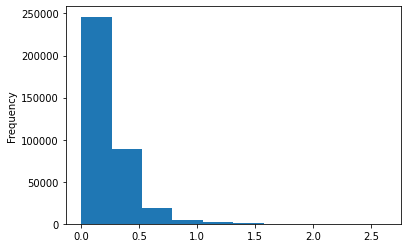

In [28]:
sales.diff_from_township_mean_sale_log10.plot.hist()

<AxesSubplot:ylabel='Frequency'>

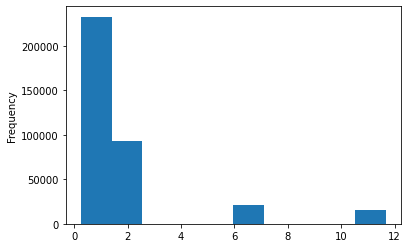

In [29]:
sales.township_avg_change.plot.hist()

## Between transactions for the same property

In [30]:
dups = sales[sales.pin.duplicated(keep=False)]

In [31]:
dups

,township,pin,year,class_x,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,homestead_exemption_senior_citizens_assessment_freeze,class_y,sqft,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10
8,24,10271020260000,2020,203,2020-10-13 00:00:00+00:00,445000.0,5.648360,7093981.0,2031439185,01,...,0.0,203,1359.0,1955.0,327.446652,0.004156,0.893617,0.498589,5.498428,0.149932
15,28,27252120050000,2019,234,2019-07-01 00:00:00+00:00,245000.0,5.389166,97517996.0,1920008051,01,...,0.0,234,1095.0,1972.0,223.744292,0.004922,NaN,0.324318,5.397890,0.008724
23,72,19362161140000,2019,205,2019-11-01 00:00:00+00:00,78300.0,4.893762,96850892.0,1932906054,05,...,0.0,205,1082.0,1942.0,72.365989,0.004523,NaN,1.814586,5.170645,0.276883
26,12,33074040010000,2019,278,2019-07-01 00:00:00+00:00,160600.0,5.205746,96145623.0,1919755036,05,...,0.0,278,2743.0,1992.0,58.549034,0.001898,NaN,1.339062,5.072808,0.132937
27,12,33074040010000,2019,278,2019-11-01 00:00:00+00:00,141000.0,5.149219,97667215.0,1935740004,05,...,0.0,278,2743.0,1992.0,51.403573,0.001877,-0.122042,1.339062,5.072808,0.076411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362165,77,13362300820000,2021,207,2021-12-29 00:00:00+00:00,750000.0,5.875061,7290833.0,2201855348,01,...,NaN,207,1852.0,2021.0,404.967603,0.003172,NaN,0.977163,5.556069,0.318992
362166,77,13362300820000,2021,207,2021-12-29 00:00:00+00:00,750000.0,5.875061,7290833.0,2201855348,01,...,NaN,211,1360.0,1890.0,551.470588,0.004320,0.000000,0.977163,5.556069,0.318992
362169,77,16023250270000,2018,203,2018-05-01 00:00:00+00:00,125000.0,5.096910,98411169.0,1813629110,01,...,0.0,203,1396.0,1903.0,89.541547,0.003651,NaN,0.977163,5.556069,0.459159
362171,71,12244000120000,2021,202,2021-01-28 00:00:00+00:00,525000.0,5.720159,7178026.0,2113001387,01,...,0.0,202,831.0,1930.0,631.768953,0.006883,1.441860,0.657466,5.502179,0.217980


In [32]:
v_counts = dups.pin.value_counts().reset_index().rename(columns={'index':'pin', 'pin':'counts'})

In [33]:
def is_outlier_column(df: pd.DataFrame, col: str):
    """
    Function that calculates outliers for pandas columns.
    Contrat with is_outlier_groupby().
    """
    lower_limit = df[col].mean() - (df[col].std() * 4)
    upper_limit = df[col].mean() + (df[col].std() * 4)
    return df[~df[col].between(lower_limit, upper_limit)]


In [34]:
count_outliers = is_outlier_column(v_counts, 'counts')

<AxesSubplot:ylabel='Frequency'>

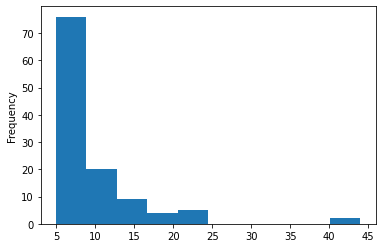

In [35]:
count_outliers.counts.plot.hist()

In [37]:
count_overlap = pd.merge(count_outliers, std_outliers)
count_overlap

,pin,counts,year,township,class_x,sale_date,sale_price,sale_price_log10,sale_key,doc_no,...,is_buyer_exercising_an_option_to_purchase,is_simultaneous_trade_of_property,is_sale_leaseback,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,class_y,sqft,year_built
0,13183070110000,6,2020,26,211,2020-02-01 00:00:00+00:00,57000.0,4.755875,97811767.0,2006347065,...,0,0,0,0,0.0,0.0,0.0,205,1296.0,1930.0
1,13183070110000,6,2020,26,211,2020-02-01 00:00:00+00:00,57000.0,4.755875,97811767.0,2006347065,...,0,0,0,0,0.0,0.0,0.0,211,2981.0,1946.0
2,27174040460000,5,2020,28,295,2020-09-01 00:00:00+00:00,6250000.0,6.795880,97334564.0,2030501402,...,None,None,None,None,NaN,NaN,NaN,295,1843.0,2016.0
3,27174040460000,5,2020,28,295,2020-09-01 00:00:00+00:00,6250000.0,6.795880,97334564.0,2030501402,...,None,None,None,None,NaN,NaN,NaN,295,1859.0,2016.0
4,27174040460000,5,2020,28,295,2020-09-01 00:00:00+00:00,6250000.0,6.795880,97334564.0,2030501402,...,None,None,None,None,NaN,NaN,NaN,295,2060.0,2016.0
5,27174040460000,5,2020,28,295,2020-09-01 00:00:00+00:00,6250000.0,6.795880,97334564.0,2030501402,...,None,None,None,None,NaN,NaN,NaN,295,2135.0,2016.0
6,27174040460000,5,2020,28,295,2020-09-01 00:00:00+00:00,6250000.0,6.795880,97334564.0,2030501402,...,None,None,None,None,NaN,NaN,NaN,295,2138.0,2016.0


In [38]:
volatile_outliers = sales.dropna(subset=['pct'])[sales.groupby('township')['pct'].apply(is_outlier_groupby)]

/tmp/ipykernel_110481/1149633570.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  volatile_outliers = sales.dropna(subset=['pct'])[sales.groupby('township')['pct'].apply(is_outlier_groupby)]


In [39]:
volatile_outliers

,township,pin,year,class_x,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,homestead_exemption_senior_citizens_assessment_freeze,class_y,sqft,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10
50,39,24024180110000,2021,278,2021-02-08 00:00:00+00:00,465000.0,5.667453,7174665.0,2110407210,01,...,NaN,278,3136.0,2019.0,148.278061,0.001807,12.285714,0.887907,5.243303,0.424150
64,12,32211010110000,2020,205,2020-09-21 00:00:00+00:00,122000.0,5.086360,7107784.0,2035813185,01,...,0.0,205,1144.0,1914.0,106.643357,0.004446,9.166667,1.339062,5.072808,0.013551
1005,38,3192060240000,2021,278,2021-04-20 00:00:00+00:00,1125000.0,6.051153,7204552.0,2116046048,01,...,0.0,278,3726.0,2021.0,301.932367,0.001624,3.500000,0.426957,5.438275,0.612877
1567,22,9094030681844,2019,299,2019-11-01 00:00:00+00:00,2650730.0,6.423365,98297404.0,1935817043,02,...,NaN,299,870.0,1973.0,3046.816092,0.007383,87.357667,0.988923,5.448227,0.975138
1895,17,11192210161034,2019,299,2019-06-01 00:00:00+00:00,200000.0,5.301030,97295401.0,1917049065,01,...,0.0,299,1000.0,1983.0,200.000000,0.005301,5.060606,0.403150,5.554365,0.253335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359971,73,14054020411084,2020,299,2020-05-01 00:00:00+00:00,9142052.0,6.961044,98223976.0,2022034021,05,...,NaN,299,NaN,1954.0,NaN,NaN,64.300371,2.171017,5.572219,1.388824
360385,20,12254100160000,2021,205,2021-07-20 00:00:00+00:00,625000.0,5.795880,7228673.0,2122134072,05,...,4002.7,202,883.0,1918.0,707.814270,0.006564,6.352941,0.685466,5.343233,0.452647
360474,19,22293020200000,2021,278,2021-01-21 00:00:00+00:00,567000.0,5.753583,7168153.0,2110407393,01,...,0.0,278,712.0,1891.0,796.348315,0.008081,3.725000,0.385977,5.579571,0.174012
361780,13,28144220250000,2021,202,2021-08-07 00:00:00+00:00,155000.0,5.190332,7226215.0,2123134082,01,...,NaN,202,1082.0,1941.0,143.253235,0.004797,6.045455,0.897264,5.166766,0.023566


<AxesSubplot:ylabel='Frequency'>

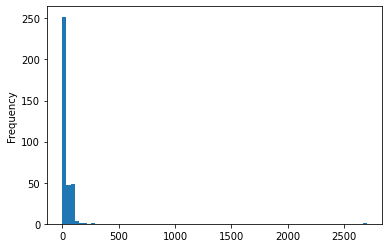

In [40]:
volatile_outliers.pct.plot.hist(bins=75)

In [41]:
voverlap = pd.merge(std_outliers, volatile_outliers)
voverlap

,pin,year,township,class_x,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,homestead_exemption_senior_citizens_assessment_freeze,class_y,sqft,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10
0,11303160211016,2019,75,299,2019-10-01 00:00:00+00:00,3093114.0,6.490396,96368599.0,1930106183,05,...,NaN,299,NaN,1930.0,NaN,NaN,28.458229,0.567762,5.337929,1.152467
1,13221030040000,2020,71,211,2020-02-01 00:00:00+00:00,10000000.0,7.000000,98404757.0,2005913075,05,...,NaN,211,4888.0,1913.0,2045.826514,0.001432,7.333333,0.657466,5.502179,1.497821
2,14054020411025,2020,73,299,2020-05-01 00:00:00+00:00,9142052.0,6.961044,97667654.0,2022034021,05,...,NaN,299,NaN,1954.0,NaN,NaN,69.323477,2.171017,5.572219,1.388824
3,14054020411075,2020,73,299,2020-05-01 00:00:00+00:00,9142052.0,6.961044,96963068.0,2022034021,05,...,NaN,299,NaN,1954.0,NaN,NaN,64.300371,2.171017,5.572219,1.388824
4,17153040641207,2022,76,299,2022-03-17 00:00:00+00:00,67500000.0,7.829304,7311824.0,2208457020,05,...,NaN,299,NaN,2007.0,NaN,NaN,2699.000000,11.660976,5.565934,2.263370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,14054020411001,2020,73,299,2020-05-01 00:00:00+00:00,9142052.0,6.961044,97111908.0,2022034021,05,...,NaN,299,NaN,1954.0,NaN,NaN,70.352601,2.171017,5.572219,1.388824
75,14054020411003,2020,73,299,2020-05-01 00:00:00+00:00,9142052.0,6.961044,96295238.0,2022034021,05,...,NaN,299,NaN,1954.0,NaN,NaN,82.109564,2.171017,5.572219,1.388824
76,14054020411036,2020,73,299,2020-05-01 00:00:00+00:00,9142052.0,6.961044,98112965.0,2022034021,05,...,NaN,299,NaN,1954.0,NaN,NaN,69.323477,2.171017,5.572219,1.388824
77,14054020411018,2020,73,299,2020-05-01 00:00:00+00:00,9142052.0,6.961044,96963010.0,2022034021,05,...,NaN,299,NaN,1954.0,NaN,NaN,77.810793,2.171017,5.572219,1.388824


In [42]:
vol_overlap = pd.merge(volatile_outliers, sqft_outliers)
vol_overlap

,township,pin,year,class_x,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,homestead_exemption_senior_citizens_assessment_freeze,class_y,sqft,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10
0,24,10073040120000,2021,278,2021-06-01 00:00:00+00:00,1325000.0,6.122216,7201032.0,2116121071,01,...,0.0,203,1040.0,1953.0,1274.038462,0.005887,3.732143,0.498589,5.498428,0.623788
1,24,10073040030000,2021,278,2021-07-13 00:00:00+00:00,995000.0,5.997823,7229800.0,2123513043,01,...,0.0,203,1232.0,1952.0,807.629870,0.004868,3.853659,0.498589,5.498428,0.499395
2,72,25054000040000,2019,202,2019-03-01 00:00:00+00:00,683334.0,5.834633,97777581.0,1908834067,05,...,NaN,202,930.0,1925.0,734.767742,0.006274,12.666680,1.814586,5.170645,0.663988
3,71,13221030040000,2020,211,2020-02-01 00:00:00+00:00,10000000.0,7.000000,98404757.0,2005913075,05,...,NaN,211,4888.0,1913.0,2045.826514,0.001432,7.333333,0.657466,5.502179,1.497821
4,36,19324140230000,2022,202,2022-02-23 00:00:00+00:00,534350.0,5.727826,7321895.0,2206320089,01,...,NaN,202,457.0,1950.0,1169.256018,0.012534,6.124667,0.958825,5.311288,0.416538
5,22,9154010240000,2021,278,2021-12-22 00:00:00+00:00,117500000.0,8.070038,7293269.0,2201022001,05,...,NaN,278,3126.0,1968.0,37587.971849,0.002582,269.114943,0.988923,5.448227,2.621811
6,36,19324140240000,2022,202,2022-02-23 00:00:00+00:00,534350.0,5.727826,7321894.0,2206320089,01,...,NaN,202,457.0,1950.0,1169.256018,0.012534,6.124667,0.958825,5.311288,0.416538
